# Intelligent Driver Model Notebook (Done)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data.param_data_loader2 import ParamDL2
dataset = ParamDL2()

dataset.summarize()

Datast Loaded. Preview of dataset: 
   driver  trip  congestion  cf_idx  type    time   speed  distance  \
0       1    53           0       0     0  1698.8  6.3472   33011.0   
1       1    53           0       0     0  1698.9  6.3194   33012.0   
2       1    53           0       0     0  1699.0  6.3083   33013.0   
3       1    53           0       0     0  1699.1  6.2556   33013.0   
4       1    53           0       0     0  1699.2  6.2389   33014.0   

   accelpedal  brakepedal  ...  timeHeadway  VL_theta  VL_dtheta  lv_speed  \
0         0.0           1  ...     2.294240  0.137128   0.009974    5.2847   
1         0.0           1  ...     2.304333  0.137128   0.009974    5.2569   
2         0.0           1  ...     2.278744  0.138907   0.009632    5.3083   
3         0.0           1  ...     2.277959  0.140121   0.009801    5.2556   
4         0.0           1  ...     2.264021  0.141357   0.010598    5.1764   

     lv_Ax  distanceCalibrated   lv_distance  timeSinceCF  distanceS

In [3]:
# Import models, before other cells, so there is no need to rerun some tests
from param_models import *
model = BatchIDM(dataset, seqs=["jam"], mode='gpu')

In [4]:
import time
# Test using RMSE over Gap
objective = "s_ego_pred_rmsne"

# Simulate and verify that it works
def_params = model.hyperparams.from_default(device=model.device)

# Simulate
t_s = time.perf_counter()
model.simulate(def_params, batch_size=1, pbar=True)
print(f"{model.model_name} simulated in", time.perf_counter()-t_s, "seconds")

# Compute Stats
t_s = time.perf_counter()
stats = model.compute_stats(objective)
print(f"{model.model_name} stats computed in", time.perf_counter()-t_s, "seconds")
print("Baseline parameters produced", objective, "=", stats["jam_"+objective+"_min"])

print(f"Graphing {model.model_name}")
seqs = model.get_seqs(num_samples=0,groups=["jam"], method="sequential")
model.plot_sim_results(seqs,out_dir="results/"+model.model_name+"_default", label="default", show=False, debug=False)

100%|██████████| 6278/6278 [00:03<00:00, 1944.33it/s]


IDM simulated in 3.24283877400012 seconds
IDM stats computed in 0.03474747400468914 seconds
Baseline parameters produced s_ego_pred_rmsne = tensor(0.5641, device='cuda:0')
Graphing IDM


100%|██████████| 60/60 [00:32<00:00,  1.83it/s]


In [5]:
RETUNE = True

best_params = [ 1.06452546,  0.5,         4.29951906,  2.05361199, 39.99809795]  # From a previous tune cycle
objective = "s_ego_pred_rmsne"

if RETUNE == True:
    best_params = model.ga_calibrate(objective, "jam", sol_size=1024, batch_size=256, num_generations=500)

opt_params = model.hyperparams.from_array(best_params, model.device)
model.simulate(opt_params, batch_size=1)
stats = model.compute_stats(objective)

seqs = model.get_seqs(num_samples=0,groups=["jam"], method="sequential")
model.plot_sim_results(seqs, out_dir="results/"+model.model_name+"_overall_optimized", label="overall_best", show=False, debug=False)

100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


100%|██████████| 5/5 [01:21<00:00, 16.35s/it]

Plotting Per-Param Optimize Result


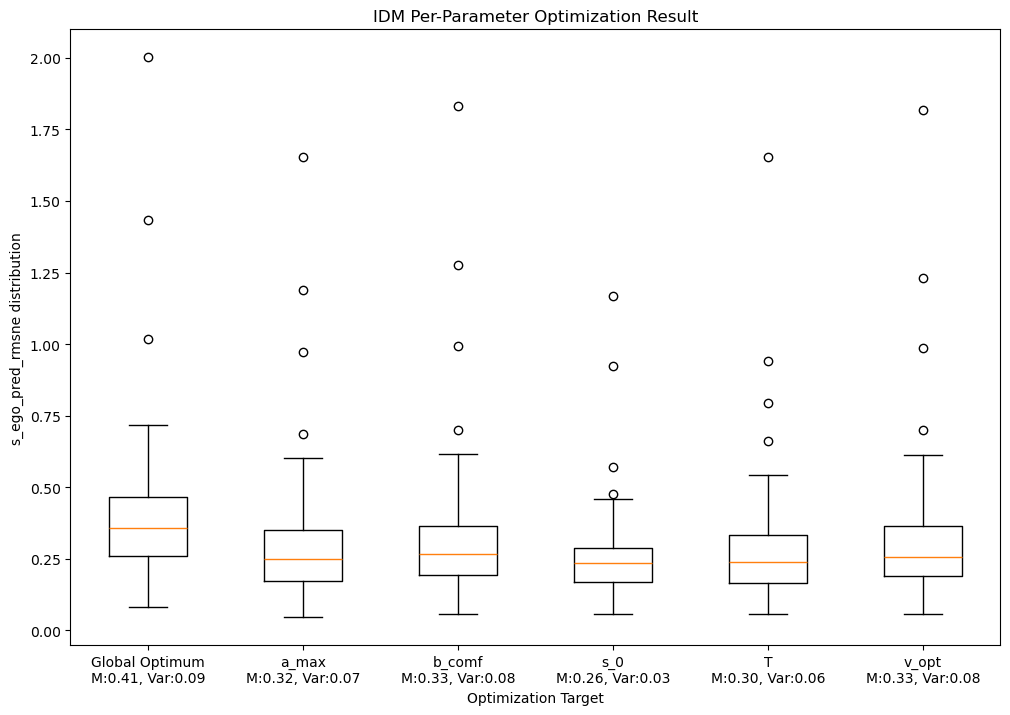

<Figure size 640x480 with 0 Axes>

In [6]:
objective = "s_ego_pred_rmsne"
opt_dict = model.per_param_optimize(best_params, objective)
model.plot_per_param_opt_overview(opt_dict)

In [7]:
model.plot_per_param_opt_indv(opt_dict, best_idx=3)

100%|██████████| 60/60 [00:34<00:00,  1.75it/s]
